In [1]:
from spodernet.preprocessing.pipeline import Pipeline, DatasetStreamer
from spodernet.preprocessing.processors import JsonLoaderProcessors, Tokenizer, AddToVocab, SaveLengthsToState, StreamToHDF5, SaveMaxLengthsToState, CustomTokenizer
from spodernet.preprocessing.processors import ConvertTokenToIdx, ApplyFunction, ToLower, DictKey2ListMapper, ApplyFunction, StreamToBatch

import random
import numpy as np
import scipy as sp
import pickle
import tensorflow as tf
import operator
from tensorflow.python.ops import gradients_impl
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix


In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f1x(x):
    ''' first order drivative of sigmoid'''
    return 1.0*(sigmoid(x)-1.0)

def f2x(x):
    ''' second order drivative of sigmoid'''
    return 1.0*sigmoid(x)*(1-sigmoid(x))

In [3]:
def dLdtheta(inputs, label, weights):
    # a: e1, b: e2, c: r
    inputs_tuple = np.array(inputs)
    def psi_function(a,b,c):
        e1 = weights[a]
        e2 = weights[b]
        r = weights[c]
        return np.dot(e1*r,e2)

    def training_loss(weights):
        e1 = weights[inputs_tuple[0]]
        e2 = weights[inputs_tuple[1]]
        r = weights[inputs_tuple[2]]
        return sigmoid(np.dot(e1*r,e2))

    def dpsi_dtheta(x,k):
        mask = np.ones(len(inputs_tuple), dtype=bool)
        mask[[x]] = False
        inputs = inputs_tuple[mask,...]
        return weights[inputs[0]][k]*weights[inputs[1]][k]
        
    # inputs_tuple: 0: e1, 1: e2, 2: rel
    psi = psi_function(inputs_tuple[0],inputs_tuple[1],inputs_tuple[2])
    dLdtheta_array = np.zeros([weights.shape[0]*weights.shape[1]])
    for i in range(len(inputs)):  
        for k1 in range(weights.shape[1]): 
            dLdtheta_val = label*f1x(psi)*dpsi_dtheta(i,k1) + (1-label)*sigmoid(psi)*dpsi_dtheta(i,k1)
            dLdtheta_array[inputs[i]*weights.shape[1]+k1] = dLdtheta_val
    dLdtheta_array = np.reshape(dLdtheta_array,[1,weights.shape[0]*weights.shape[1]])
    return dLdtheta_array

In [4]:
def get_hessian(facts_list,Y_train,weights):
    row = []
    col = []
    values = []
    for i, fact in enumerate(facts_list):
        inputs = list(fact)
        label = Y_train[i][0]
        
        inputs_tuple = np.array(inputs)
        def psi_function(a,b,c):
            # a: e1, b: e2, c: r
            e1 = weights[a]
            e2 = weights[b]
            r = weights[c]
            return np.dot(e1*r,e2)

        def training_loss(weights):
            e1 = weights[inputs_tuple[0]]
            e2 = weights[inputs_tuple[1]]
            r = weights[inputs_tuple[2]]
            return sigmoid(np.dot(e1*r,e2))

        def dpsi_dtheta(x,k):
            if x not in inputs:
                return 0
            else:
                inputs_tuple = inputs.copy()
                inputs_tuple.remove(x)
                return weights[inputs_tuple[0]][k]*weights[inputs_tuple[1]][k]

        def dpsi_dtheta_dtheta(x,y,k):
            if x not in inputs:
                return 0
            if y not in inputs:
                return 0
            if x == y and inputs.count(x) < 2:
                return 0
            else:
                inputs_tuple = inputs.copy()
                inputs_tuple.remove(x)
                inputs_tuple.remove(y)
                return weights[inputs_tuple[0]][k]
            
        # inputs_tuple: 0: e1, 1: e2, 2: rel
        psi = psi_function(inputs_tuple[0],inputs_tuple[1],inputs_tuple[2])
        for i in inputs:                      # 3 element (a,b,c)
            one_vector = []
            for k1 in range(weights.shape[1]):          # i: the element we focus, k.
                for j in inputs:              # 3 element (a,b,c)
                    for k2 in range(weights.shape[1]):  # j: the element we focus, k.
                        if k1 == k2:
                            second_drivative = label*(f2x(psi)*dpsi_dtheta(i,k1)*dpsi_dtheta(j,k2) + f1x(psi)*dpsi_dtheta_dtheta(i,j,k1)) + (1-label)*(sigmoid(psi)*(1-sigmoid(psi))*dpsi_dtheta(i,k1)*dpsi_dtheta(j,k2) + sigmoid(psi)*dpsi_dtheta_dtheta(i,j,k1))
                        else:
                            second_drivative = label*(f2x(psi)*dpsi_dtheta(i,k1)*dpsi_dtheta(j,k2)) + (1-label)*(sigmoid(psi)*(1-sigmoid(psi))*dpsi_dtheta(i,k1)*dpsi_dtheta(j,k2))
                        row.append(i*weights.shape[1]+k1)
                        col.append(j*weights.shape[1]+k2)
                        values.append((1.0/len(facts_list))*second_drivative)
    return csr_matrix((values, (row, col)), shape=(weights.shape[0]*weights.shape[1], weights.shape[0]*weights.shape[1]))


In [5]:
def get_eo_hessian(facts_list,Y_train,weights,target_x_e2):
    hessian_array = np.zeros([weights.shape[1],weights.shape[1]])
    row = []
    col = []
    values = []
    for i, fact in enumerate(facts_list):
        inputs = list(fact)
        label = Y_train[i][0]
        
        inputs_tuple = np.array(inputs)
        if inputs_tuple[1] != target_x_e2:
            continue
        def psi_function(a,b,c):
            # a: e1, b: e2, c: r
            e1 = weights[a]
            e2 = weights[b]
            r = weights[c]
            return np.dot(e1*r,e2)

        def training_loss(weights):
            e1 = weights[inputs_tuple[0]]
            e2 = weights[inputs_tuple[1]]
            r = weights[inputs_tuple[2]]
            return sigmoid(np.dot(e1*r,e2))

        def dpsi_dtheta(x,k):
            if x not in inputs:
                return 0
            else:
                inputs_tuple = inputs.copy()
                inputs_tuple.remove(x)
                return weights[inputs_tuple[0]][k]*weights[inputs_tuple[1]][k]

        def dpsi_dtheta_dtheta(x,y,k):
            if x not in inputs:
                return 0
            if y not in inputs:
                return 0
            if x == y and inputs.count(x) < 2:
                return 0
            else:
                inputs_tuple = inputs.copy()
                inputs_tuple.remove(x)
                inputs_tuple.remove(y)
                return weights[inputs_tuple[0]][k]
            
        # inputs_tuple: 0: e1, 1: e2, 2: rel
        psi = psi_function(inputs_tuple[0],inputs_tuple[1],inputs_tuple[2])
        for i in inputs:                      # 3 element (a,b,c)
            if i != target_x_e2:
                continue
            one_vector = []
            for k1 in range(weights.shape[1]):          # i: the element we focus, k.
                for j in inputs:              # 3 element (a,b,c)
                    if j != target_x_e2:
                        continue
                    for k2 in range(weights.shape[1]):  # j: the element we focus, k.
                        if k1 == k2:
                            second_drivative = label*(f2x(psi)*dpsi_dtheta(i,k1)*dpsi_dtheta(j,k2) + f1x(psi)*dpsi_dtheta_dtheta(i,j,k1)) + (1-label)*(sigmoid(psi)*(1-sigmoid(psi))*dpsi_dtheta(i,k1)*dpsi_dtheta(j,k2) + sigmoid(psi)*dpsi_dtheta_dtheta(i,j,k1))
                        else:
                            second_drivative = label*(f2x(psi)*dpsi_dtheta(i,k1)*dpsi_dtheta(j,k2)) + (1-label)*(sigmoid(psi)*(1-sigmoid(psi))*dpsi_dtheta(i,k1)*dpsi_dtheta(j,k2))
                        hessian_array[k1][k2] += (1.0/len(facts_list))*second_drivative
                        values.append((1.0/len(facts_list))*second_drivative)
    return hessian_array


def score_function(X,Y,params_val):
    score = np.dot(params_val[X[1]],np.multiply(params_val[X[0]],params_val[X[2]]))
    return score

In [6]:
''' Preprocess knowledge graph using spodernet. '''
def preprocess(dataset_name, delete_data=False):
    full_path = 'data/{0}/e1rel_to_e2_full.json'.format(dataset_name)
    train_path = 'data/{0}/e1rel_to_e2_train.json'.format(dataset_name)
    dev_ranking_path = 'data/{0}/e1rel_to_e2_ranking_dev.json'.format(dataset_name)
    test_ranking_path = 'data/{0}/e1rel_to_e2_ranking_test.json'.format(dataset_name)

    keys2keys = {}
    keys2keys['e1'] = 'e1' # entities
    keys2keys['rel'] = 'rel' # relations
    keys2keys['e2'] = 'e1' # entities
    keys2keys['e2_multi1'] = 'e1' # entity
    keys2keys['e2_multi2'] = 'e1' # entity
    input_keys = ['e1', 'rel', 'e2', 'e2_multi1', 'e2_multi2']

    d = DatasetStreamer(input_keys)
    d.add_stream_processor(JsonLoaderProcessors())
    d.add_stream_processor(DictKey2ListMapper(input_keys))
    # process full vocabulary and save it to disk
    d.set_path(full_path)
    p = Pipeline(dataset_name, delete_data, keys=input_keys, skip_transformation=True)
    p.add_sent_processor(ToLower())
    p.add_sent_processor(CustomTokenizer(lambda x: x.split(' ')),keys=['e2_multi1', 'e2_multi2'])
    p.add_token_processor(AddToVocab())
    p.execute(d)
    p.save_vocabs()
    
    # process train, dev and test sets and save them to hdf5
    p.skip_transformation = False
    for path, name in zip([train_path, dev_ranking_path, test_ranking_path], ['train', 'dev_ranking', 'test_ranking']):
        d.set_path(path)
        p.clear_processors()
        p.add_sent_processor(ToLower())
        p.add_sent_processor(CustomTokenizer(lambda x: x.split(' ')),keys=['e2_multi1', 'e2_multi2'])
        p.add_post_processor(ConvertTokenToIdx(keys2keys=keys2keys), keys=['e1', 'rel', 'e2', 'e2_multi1', 'e2_multi2'])
        p.add_post_processor(StreamToHDF5(name, samples_per_file=1000, keys=input_keys))
        p.execute(d)

In [7]:
dataset = 'kinship'
preprocess(dataset, delete_data=True)
input_keys = ['e1', 'rel', 'e2', 'e2_multi1', 'e2_multi2']
p = Pipeline(dataset, keys=input_keys)
p.load_vocabs()
vocab = p.state['vocab']

e1_num_entities = vocab['e1'].num_token
e2_num_entities = vocab['e2'].num_token
num_rels = vocab['rel'].num_token

vocab_set = set()
e1_entity_num = vocab['e1'].num_token
e2_entity_num = vocab['e2'].num_token
rel_entity_num = vocab['rel'].num_token
facts_list = []
facts_set = set()
with open('./data/{}/train.txt'.format(dataset)) as f:
    for line in f:
        fact = line.strip().split('\t')
        facts_list.append([vocab['e1'].get_idx(fact[0]), e1_entity_num + vocab['e1'].get_idx(fact[2]), e1_entity_num + e2_entity_num + vocab['rel'].get_idx(fact[1])])
        facts_set.add(tuple(facts_list[-1]))

num_positive = int(len(facts_list)*1.0)
num_negative = int(1.0*len(facts_list)*1.0)

random.seed(1)
total_facts_list = []
total_facts_x_list = []
total_facts_y_list = []
total_facts_e1_r_list_pos = []
total_facts_e1_r_list_neg = []
X_train = []
Y_train = []
for fact in facts_list[0:num_positive]:
    total_facts_list.append([fact[0],fact[1],fact[2],0.9])
    total_facts_x_list.append([fact[0],fact[1],fact[2]])
    total_facts_y_list.append([0.9])
    total_facts_e1_r_list_pos.append([fact[0],fact[2],0.9])

neg_facts_set = set()
neg_facts_list = []
for _ in range(num_negative):
    neg_tuple = (random.randint(0,e1_entity_num-1),random.randint(0,e2_entity_num-1),random.randint(0,rel_entity_num-1))
    neg_triple = [neg_tuple[0],neg_tuple[1],neg_tuple[2]]
    scale_neg_triple = [neg_tuple[0],neg_tuple[1] + e1_entity_num, neg_tuple[2]+e1_entity_num+e2_entity_num]
    if neg_tuple not in facts_set and scale_neg_triple not in total_facts_x_list and neg_triple not in neg_facts_list:
        neg_facts_set.add(neg_tuple)
        
for fact in list(neg_facts_set):
    total_facts_list.append([fact[0],fact[1]+e1_entity_num,fact[2]+e1_entity_num+e2_entity_num,0.1])
    total_facts_x_list.append([fact[0],fact[1]+e1_entity_num,fact[2]+e1_entity_num+e2_entity_num])
    total_facts_y_list.append([0.1])
    total_facts_e1_r_list_neg.append([fact[0],fact[2]+e1_entity_num+e2_entity_num,0.1])

random.shuffle(total_facts_list)
X_train = np.array([[fact[0],fact[1],fact[2]] for fact in total_facts_list[0:-10]])
Y_train = np.array([[fact[3]] for fact in total_facts_list[0:-10]])

X_test = np.array([[fact[0],fact[1],fact[2]] for fact in total_facts_list[-10:]])
Y_test = np.array([[fact[3]] for fact in total_facts_list[-10:]])

emb_size = e1_entity_num+e2_entity_num+rel_entity_num

X_train_scale = X_train-[0,e1_entity_num,e1_entity_num+e2_entity_num]
X_test_scale = X_test-[0,e1_entity_num,e1_entity_num+e2_entity_num]


2019-06-17 11:29:43.696444 (WARNING): delete_all_previous_data=True! Deleting all folder contents of folder /Users/yifantian/.data/kinship!
2019-06-17 11:29:43.726502 (INFO): Recreating path: /Users/yifantian/.data/kinship
2019-06-17 11:29:43.841823 (INFO): Time taken for 10000 samples for input type e2_multi1 for processor AddToVocab: 0.02 seconds
2019-06-17 11:29:44.045695 (INFO): Time taken for 10000 samples for input type e2_multi2 for processor ToLower: 0.01 seconds
2019-06-17 11:29:44.145419 (INFO): Saving vocab to: /Users/yifantian/.data/kinship/vocab
2019-06-17 11:29:44.146263 (INFO): Saving vocab to: /Users/yifantian/.data/kinship/vocab_e1
2019-06-17 11:29:44.146985 (INFO): Saving vocab to: /Users/yifantian/.data/kinship/vocab_rel
2019-06-17 11:29:44.147578 (INFO): Saving vocab to: /Users/yifantian/.data/kinship/vocab_e2
2019-06-17 11:29:44.148266 (INFO): Saving vocab to: /Users/yifantian/.data/kinship/vocab_e2_multi1
2019-06-17 11:29:44.149108 (INFO): Saving vocab to: /Users/

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
len x_train all: 16729
EPOCH 0
Loss:  0.7018621
Norm of the mean of gradients: 0.0058046863
Norm of the params: 12.399008
len x_train all: 16729
EPOCH 2000
Loss:  0.5942129
Norm of the mean of gradients: 0.0077240295
Norm of the params: 17.808582
len x_train all: 16729
EPOCH 4000
Loss:  0.55281323
Norm of the mean of gradients: 0.000500276
Norm of the params: 19.588469
len x_train all: 16729
EPOCH 6000
Loss:  0.5527428
Norm of the mean of gradients: 5.7166684e-08
Norm of the params: 19.733747
len x_train all: 16729
EPOCH 8000
Loss:  0.5527428
Norm of the mean of gradients: 1.9846702e-08
Norm of the params: 19.733772
Model saved in path: ./adding_tmp/kinship/model.ckpt
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from 

Diff in params: 0.045038365
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38026202
Difference in loss after retraining     : -0.0023437142
Difference in loss after using real weight change : [-0.00236678]
Predicted difference in loss no hessian (influence): 1.6047234094551228e-06
Predicted difference in loss with hessian (influence): [-0.00241791]
Predicted difference in loss with e2 hessian (influence): [-0.00200725]
Predicted difference in loss with e2_onsite hessian (influence): [-0.00200725]
change of target score:  0.018175602
predicted change of score:  0.01856517985953343
predicted_target_score_diffs_only_eo_function:  [[0.01537441]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.043868385
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38032603
Difference in loss after retraining     : -0.0022796988
Difference in loss after using real 

Diff in params: 0.059086576
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38055944
Difference in loss after retraining     : -0.002046287
Difference in loss after using real weight change : [-0.00206239]
Predicted difference in loss no hessian (influence): 7.539196254440457e-07
Predicted difference in loss with hessian (influence): [-0.00209654]
Predicted difference in loss with e2 hessian (influence): [-0.00175341]
Predicted difference in loss with e2_onsite hessian (influence): [-0.00175341]
change of target score:  0.015843272
predicted change of score:  0.0161021294510304
predicted_target_score_diffs_only_eo_function:  [[0.01343018]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.036432266
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3806111
Difference in loss after retraining     : -0.0019946396
Difference in loss after using real weig

Diff in params: 0.04145647
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38106272
Difference in loss after retraining     : -0.0015430152
Difference in loss after using real weight change : [-0.00155169]
Predicted difference in loss no hessian (influence): 9.081679435802151e-07
Predicted difference in loss with hessian (influence): [-0.00155491]
Predicted difference in loss with e2 hessian (influence): [-0.00147406]
Predicted difference in loss with e2_onsite hessian (influence): [-0.00147406]
change of target score:  0.0119149685
predicted change of score:  0.011939479052658353
predicted_target_score_diffs_only_eo_function:  [[0.01129052]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.039005622
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3810702
Difference in loss after retraining     : -0.0015355349
Difference in loss after using real w

Diff in params: 0.010831346
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38180444
Difference in loss after retraining     : -0.00080129504
Difference in loss after using real weight change : [-0.00080462]
Predicted difference in loss no hessian (influence): 1.2671877021847698e-06
Predicted difference in loss with hessian (influence): [-0.000803]
Predicted difference in loss with e2 hessian (influence): [-0.00079267]
Predicted difference in loss with e2_onsite hessian (influence): [-0.00079267]
change of target score:  0.0061632395
predicted change of score:  0.006150816968313544
predicted_target_score_diffs_only_eo_function:  [[0.00607142]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.010100546
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3818133
Difference in loss after retraining     : -0.00079244375
Difference in loss after using real

Diff in params: 0.010424854
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.381955
Difference in loss after retraining     : -0.0006507337
Difference in loss after using real weight change : [-0.00065293]
Predicted difference in loss no hessian (influence): 1.2483154069188037e-06
Predicted difference in loss with hessian (influence): [-0.00066017]
Predicted difference in loss with e2 hessian (influence): [-0.00072136]
Predicted difference in loss with e2_onsite hessian (influence): [-0.00072136]
change of target score:  0.005001664
predicted change of score:  0.005056744453509454
predicted_target_score_diffs_only_eo_function:  [[0.00552519]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.012271135
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3819564
Difference in loss after retraining     : -0.000649333
Difference in loss after using real wei

Diff in params: 0.012772152
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3821243
Difference in loss after retraining     : -0.00048142672
Difference in loss after using real weight change : [-0.00048243]
Predicted difference in loss no hessian (influence): 1.1483020846675122e-06
Predicted difference in loss with hessian (influence): [-0.000483]
Predicted difference in loss with e2 hessian (influence): [-0.00056076]
Predicted difference in loss with e2_onsite hessian (influence): [-0.00056076]
change of target score:  0.003697276
predicted change of score:  0.003701426382572759
predicted_target_score_diffs_only_eo_function:  [[0.00429513]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.009748175
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38213062
Difference in loss after retraining     : -0.00047510862
Difference in loss after using real 

Diff in params: 0.012719957
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38235545
Difference in loss after retraining     : -0.0002502799
Difference in loss after using real weight change : [-0.0002504]
Predicted difference in loss no hessian (influence): 1.1271411625731761e-07
Predicted difference in loss with hessian (influence): [-0.00022493]
Predicted difference in loss with e2 hessian (influence): [-0.00012385]
Predicted difference in loss with e2_onsite hessian (influence): [-0.00012385]
change of target score:  0.0019193888
predicted change of score:  0.0017242547490194937
predicted_target_score_diffs_only_eo_function:  [[0.00094861]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.010727691
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3823673
Difference in loss after retraining     : -0.00023841858
Difference in loss after using rea

Diff in params: 0.011066281
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3824679
Difference in loss after retraining     : -0.00013783574
Difference in loss after using real weight change : [-0.00013791]
Predicted difference in loss no hessian (influence): 6.815161984895974e-08
Predicted difference in loss with hessian (influence): [-0.00012501]
Predicted difference in loss with e2 hessian (influence): [-0.00015551]
Predicted difference in loss with e2_onsite hessian (influence): [-0.00015551]
change of target score:  0.0010569096
predicted change of score:  0.0009580769350625573
predicted_target_score_diffs_only_eo_function:  [[0.0011911]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.008027988
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.382478
Difference in loss after retraining     : -0.00012773275
Difference in loss after using real 

Diff in params: 0.011803152
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3827664
Difference in loss after retraining     : 0.00016066432
Difference in loss after using real weight change : [0.00016063]
Predicted difference in loss no hessian (influence): -9.199940534421565e-08
Predicted difference in loss with hessian (influence): [0.00017733]
Predicted difference in loss with e2 hessian (influence): [0.00010882]
Predicted difference in loss with e2_onsite hessian (influence): [0.00010882]
change of target score:  -0.0012292862
predicted change of score:  -0.0013572207225003297
predicted_target_score_diffs_only_eo_function:  [[-0.00083352]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.013885701
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38274762
Difference in loss after retraining     : 0.00014188886
Difference in loss after using real

Diff in params: 0.01222412
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38287312
Difference in loss after retraining     : 0.00026738644
Difference in loss after using real weight change : [0.00026707]
Predicted difference in loss no hessian (influence): -1.723953854040775e-07
Predicted difference in loss with hessian (influence): [0.00029804]
Predicted difference in loss with e2 hessian (influence): [0.00016732]
Predicted difference in loss with e2_onsite hessian (influence): [0.00016732]
change of target score:  -0.002044797
predicted change of score:  -0.0022816466704982385
predicted_target_score_diffs_only_eo_function:  [[-0.00128157]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.017546438
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3829413
Difference in loss after retraining     : 0.00033557415
Difference in loss after using real w

Diff in params: 0.023891618
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38335443
Difference in loss after retraining     : 0.00074869394
Difference in loss after using real weight change : [0.00074684]
Predicted difference in loss no hessian (influence): -1.8495026394886071e-06
Predicted difference in loss with hessian (influence): [0.00079364]
Predicted difference in loss with e2 hessian (influence): [0.0008807]
Predicted difference in loss with e2_onsite hessian (influence): [0.0008807]
change of target score:  -0.005711913
predicted change of score:  -0.006071582740446724
predicted_target_score_diffs_only_eo_function:  [[-0.00674567]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.017824212
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3834053
Difference in loss after retraining     : 0.0007995665
Difference in loss after using real wei

Diff in params: 0.043688472
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38385442
Difference in loss after retraining     : 0.0012486875
Difference in loss after using real weight change : [0.00124688]
Predicted difference in loss no hessian (influence): -3.480620072529159e-06
Predicted difference in loss with hessian (influence): [0.00135597]
Predicted difference in loss with e2 hessian (influence): [0.00150933]
Predicted difference in loss with e2_onsite hessian (influence): [0.00150933]
change of target score:  -0.009503007
predicted change of score:  -0.010341705291099013
predicted_target_score_diffs_only_eo_function:  [[-0.01156067]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.04390026
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38395923
Difference in loss after retraining     : 0.0013535023
Difference in loss after using real wei

Diff in params: 0.047652703
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3843861
Difference in loss after retraining     : 0.0017803609
Difference in loss after using real weight change : [0.00177136]
Predicted difference in loss no hessian (influence): -9.92604702313836e-07
Predicted difference in loss with hessian (influence): [0.00186914]
Predicted difference in loss with e2 hessian (influence): [0.00152155]
Predicted difference in loss with e2_onsite hessian (influence): [0.00152155]
change of target score:  -0.013512135
predicted change of score:  -0.014263630234198965
predicted_target_score_diffs_only_eo_function:  [[-0.01165426]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.048208416
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38440737
Difference in loss after retraining     : 0.0018016398
Difference in loss after using real weig

Diff in params: 0.045065045
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38493586
Difference in loss after retraining     : 0.0023301244
Difference in loss after using real weight change : [0.00230418]
Predicted difference in loss no hessian (influence): -1.8133152822077442e-06
Predicted difference in loss with hessian (influence): [0.00243225]
Predicted difference in loss with e2 hessian (influence): [0.00208725]
Predicted difference in loss with e2_onsite hessian (influence): [0.00208725]
change of target score:  -0.017634988
predicted change of score:  -0.018615090325375006
predicted_target_score_diffs_only_eo_function:  [[-0.01598717]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.045072336
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3849274
Difference in loss after retraining     : 0.0023216605
Difference in loss after using real we

Diff in params: 0.09752553
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3851482
Difference in loss after retraining     : 0.002542466
Difference in loss after using real weight change : [0.0025106]
Predicted difference in loss no hessian (influence): -1.6599117736877975e-06
Predicted difference in loss with hessian (influence): [0.00302681]
Predicted difference in loss with e2 hessian (influence): [0.00296684]
Predicted difference in loss with e2_onsite hessian (influence): [0.00296684]
change of target score:  -0.01922214
predicted change of score:  -0.023189762911311362
predicted_target_score_diffs_only_eo_function:  [[-0.02272438]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.03520975
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3855031
Difference in loss after retraining     : 0.0028973818
Difference in loss after using real weight c

Diff in params: 0.08103763
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38609403
Difference in loss after retraining     : 0.0034883022
Difference in loss after using real weight change : [0.00343808]
Predicted difference in loss no hessian (influence): -7.971129846969076e-06
Predicted difference in loss with hessian (influence): [0.00390615]
Predicted difference in loss with e2 hessian (influence): [0.00402989]
Predicted difference in loss with e2_onsite hessian (influence): [0.00402989]
change of target score:  -0.026247859
predicted change of score:  -0.02985011327156739
predicted_target_score_diffs_only_eo_function:  [[-0.03086674]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.088283345
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38619733
Difference in loss after retraining     : 0.003591597
Difference in loss after using real weigh

Diff in params: 0.055673685
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.3874947
Difference in loss after retraining     : 0.0048889816
Difference in loss after using real weight change : [0.00476676]
Predicted difference in loss no hessian (influence): -6.137876835133899e-06
Predicted difference in loss with hessian (influence): [0.00512085]
Predicted difference in loss with e2 hessian (influence): [0.0047867]
Predicted difference in loss with e2_onsite hessian (influence): [0.00478669]
change of target score:  -0.036533594
predicted change of score:  -0.039256217511463465
predicted_target_score_diffs_only_eo_function:  [[-0.03666347]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.09565467
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.38735032
Difference in loss after retraining     : 0.0047445893
Difference in loss after using real weigh

Diff in params: 0.07764902
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.39005312
Difference in loss after retraining     : 0.0074473917
Difference in loss after using real weight change : [0.00716843]
Predicted difference in loss no hessian (influence): -1.0967324116260083e-05
Predicted difference in loss with hessian (influence): [0.0078597]
Predicted difference in loss with e2 hessian (influence): [0.00749272]
Predicted difference in loss with e2_onsite hessian (influence): [0.00749272]
change of target score:  -0.054969788
predicted change of score:  -0.06029808387654301
predicted_target_score_diffs_only_eo_function:  [[-0.05739013]]
INFO:tensorflow:Restoring parameters from ./adding_tmp/kinship/model.ckpt
Diff in params: 0.11589043
Loss on test idx with original model    : 0.38260573
Loss on test idx with retrained model   : 0.39042178
Difference in loss after retraining     : 0.0078160465
Difference in loss after using real weigh

(131, 0.005658865) -0.04647040400421343 [ 56 169 224]
(165, 0.0057830513) -0.04717345636351222 [ 80 123 219]
(143, 0.005923271) -0.0483801433380997 [100 142 225]
(139, 0.0064110756) -0.052313081253070104 [ 28 167 230]
(20, 0.0065619648) -0.05207920945689093 [ 27 167 217]
(80, 0.0067551434) -0.055792626449670424 [ 31 166 214]
(195, 0.0074473917) -0.06029808387654301 [ 14 125 227]
(14, 0.0076714754) -0.0703248364921727 [ 89 195 235]
(158, 0.0078160465) -0.06492000557201694 [ 43 208 235]
(55, 0.008251458) -0.06677208609304319 [  5 123 234]


[]

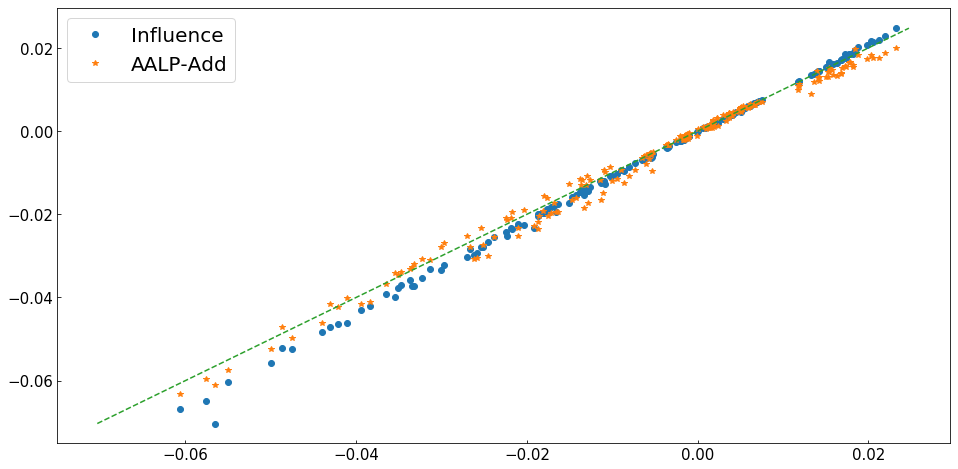

In [8]:
test_idx = 0
target_x = X_test[test_idx:test_idx+1][0]
target_y = Y_test[test_idx:test_idx+1][0]
X_add_all_list = []
Y_add_all_list = []
X_add_nei_list = []
Y_add_nei_list = []
X_add_no_nei_list = []
Y_add_no_nei_list = []
for i in range(e1_entity_num):
    for j in range(e2_entity_num):
        for k in range(rel_entity_num):
            triple = [i,j,k]
            fact_triple = [i, j+e1_entity_num, k + e1_entity_num + e2_entity_num]
            if fact_triple in total_facts_x_list:
                continue
            X_add_all_list.append(triple)
            Y_add_all_list.append([0.9])
            if i != target_x[0] and j == target_x[1]-e1_entity_num and k != target_x[2] - e1_entity_num - e2_entity_num:

                X_add_nei_list.append(triple)
                Y_add_nei_list.append([0.9])
            else:
                X_add_no_nei_list.append(triple)
                Y_add_no_nei_list.append([0.9])

random.shuffle(X_add_no_nei_list)
X_add_list = X_add_nei_list
Y_add_list = Y_add_nei_list

random.shuffle(X_add_list)

X_train_add_scale = np.array(X_add_list[0:200])
Y_train_add_scale = np.array(Y_add_list[0:200])

tf.reset_default_graph()
emb_dim = 2

tf.set_random_seed(1234)
input_x = tf.placeholder(
    tf.int32, 
    shape=(None, 3),
    name='input_placeholder')
labels = tf.placeholder(
    tf.float32,             
    shape=(None),
    name='labels_placeholder')

x_e1 = input_x[:,0]
x_e2 = input_x[:,1]
x_rel = input_x[:,2]

e1_embeddings = tf.Variable(tf.random_uniform([e1_entity_num, emb_dim], -1.0, 1.0),name="e1_emb")
e2_embeddings = tf.Variable(tf.random_uniform([e2_entity_num, emb_dim], -1.0, 1.0),name="e2_emb")
rel_embeddings = tf.Variable(tf.random_uniform([rel_entity_num, emb_dim], -1.0, 1.0),name="rel_emb")
e1 = tf.nn.embedding_lookup(e1_embeddings, x_e1)
e2 = tf.nn.embedding_lookup(e2_embeddings, x_e2)
rel = tf.nn.embedding_lookup(rel_embeddings, x_rel)

e1_rel = tf.multiply(e1, rel)
logits = tf.reduce_sum(tf.multiply(e1_rel, e2),1,keepdims=True)
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits))
total_loss = cross_entropy

all_params = []
for layer in ['e1_emb', 'e2_emb','rel_emb']: 
    temp_tensor = tf.get_default_graph().get_tensor_by_name("%s:0" % (layer)) 
    all_params.append(temp_tensor)   
params = all_params
gradients = tf.gradients(total_loss, params)

grad_total_loss_op = []
for grad in gradients:
    if isinstance(grad, tf.IndexedSlices):
        grad_total_loss_op.append(tf.reshape(gradients_impl._IndexedSlicesToTensor(grad),[-1]))
    else:
        grad_total_loss_op.append(grad)

train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(total_loss)
partial_train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(total_loss,var_list=[e2_embeddings])
hessians = tf.hessians(total_loss, params)

actual_loss_diffs = dict()
predicted_loss_diffs0 = dict()
predicted_loss_diffs = dict()
predicted_loss_diffs_high_order = dict()
predicted_loss_diffs_reduce_hessian = dict()
predicted_loss_diffs_e2 = dict()
predicted_loss_diffs_e2_onsite = dict()
predicted_loss_diffs_no_hessian = dict()

predicted_target_score_diffs_hessian = dict()
predicted_score_diffs_no_hessian = dict()
predicted_target_score_diffs_only_eo_function = dict()
actual_new_target_score_diffs = dict()
adding_triple_score_dict = dict()

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    train_steps = 10000
    perm = [True for _ in range(len(X_train_scale))]
    x_batch = X_train_scale[perm, :]
    labels_batch = Y_train[perm]
    for i in range(train_steps):
        _, loss_val = sess.run([train_op,total_loss], feed_dict={input_x: x_batch, labels: labels_batch})
        if i % 2000 == 0:
            print('len x_train all:',len(x_batch))
            print('EPOCH', i)
            print("Loss: ", loss_val)
            params_val = sess.run(params)
            grad_loss_val = sess.run(grad_total_loss_op, feed_dict={input_x: x_batch, labels: labels_batch})
            print('Norm of the mean of gradients: %s' % np.linalg.norm(np.concatenate(grad_loss_val)))
            print('Norm of the params: %s' % np.linalg.norm(np.concatenate(params_val)))

    save_path = saver.save(sess, "./adding_tmp/{}/model.ckpt".format(dataset))
    print("Model saved in path: %s" % save_path)

    # prepare influence
    params_val = sess.run(params)
    params_val = np.concatenate(params_val,axis = 0)

    old_target_score = score_function(target_x,target_y,params_val)
    Y = np.multiply(np.reshape(params_val[target_x[0]], (1, -1)), np.reshape(params_val[target_x[2]], (1, -1)))

    target_x_e2 = X_test_scale[test_idx:test_idx+1][0][1]
    test_grad_check = dLdtheta(X_test[test_idx:test_idx+1][0],Y_test[test_idx:test_idx+1][0][0],params_val)
    all_test_grad = sess.run(grad_total_loss_op, feed_dict={input_x: X_test_scale[test_idx:test_idx+1], labels: Y_test[test_idx:test_idx+1]})
    test_grad = np.concatenate(all_test_grad,axis = 0)
    test_grad_e2 = all_test_grad[1]
    test_loss_val = sess.run(cross_entropy, feed_dict={input_x: X_test_scale[test_idx:test_idx+1], labels: Y_test[test_idx:test_idx+1]})

    original_trainset_grad = sess.run(grad_total_loss_op, feed_dict={input_x: x_batch, labels: labels_batch})
    original_trainset_grad = np.concatenate(original_trainset_grad,axis = 0)

    hessian = sess.run(hessians,feed_dict={input_x: X_train_scale, labels: Y_train})
    hessian_matrix_e1 = np.reshape(hessian[0],[emb_dim*e1_entity_num,emb_dim*e1_entity_num])
    hessian_matrix_e2 = np.reshape(hessian[1],[emb_dim*e2_entity_num,emb_dim*e2_entity_num])
    hessian_matrix_e3 = np.reshape(hessian[2],[emb_dim*rel_entity_num,emb_dim*rel_entity_num])
    hessian_matrix_e2_inv = inv(hessian_matrix_e2)

    hessian_sparse = get_hessian(X_train,Y_train,params_val)
    hessian_matrix = hessian_sparse.toarray()
    hessian_matrix_1d = np.reshape(hessian_matrix,[-1])
    hessian_inv = inv(hessian_matrix)
    hessian_inv_1d = np.reshape(hessian_inv,[-1])

    test_grad_e2_onsite = test_grad_e2[emb_dim*target_x_e2:emb_dim*target_x_e2+emb_dim]
    hessian_matrix_e2_onsite = get_eo_hessian(X_train,Y_train,params_val,target_x_e2+e1_entity_num)
    hessian_matrix_e2_onsite_inv = inv(hessian_matrix_e2_onsite)

    for train_idx in range(len(X_train_add_scale)):
        all_train_grad = sess.run(grad_total_loss_op,feed_dict={input_x: X_train_add_scale[train_idx:train_idx+1], labels: Y_train_add_scale[train_idx:train_idx+1]})
        train_grad = np.concatenate(all_train_grad,axis = 0)
        train_grad_e2 = all_train_grad[1]
        train_grad_e2_onsite = train_grad_e2[emb_dim*target_x_e2:emb_dim*target_x_e2+emb_dim]
        attack_factor = -1.0   # -1.0 for adding, 1.0 for removing
        pred_dweight = attack_factor*(1.0/len(X_train))*np.dot(hessian_inv,np.expand_dims(train_grad,axis=1))
        reshape_pred_dweight_no_hessian_dweight = np.reshape(attack_factor*(1.0/len(X_train))*np.transpose(train_grad),[-1,emb_dim])
        pred_dweight_e2 = attack_factor*(1.0/len(X_train))*np.dot(hessian_matrix_e2_inv,np.expand_dims(train_grad_e2,axis=1))
        pred_dweight_e2_onsite = attack_factor*(1.0/len(X_train))*np.dot(hessian_matrix_e2_onsite_inv,np.expand_dims(train_grad_e2_onsite,axis=1))

        predicted_loss_diffs[train_idx] = np.dot(test_grad, pred_dweight)
        predicted_loss_diffs_e2[train_idx] = np.dot(test_grad_e2, pred_dweight_e2)
        predicted_loss_diffs_e2_onsite[train_idx] = np.dot(test_grad_e2_onsite, pred_dweight_e2_onsite)        
        predicted_loss_diffs_no_hessian[train_idx] = (1.0/len(X_train))*np.dot(test_grad, np.transpose(train_grad))

        add_triple_X, add_triple_Y = X_train_add_scale[[train_idx]], Y_train_add_scale[[train_idx]]
        adding_triple_score_dict[train_idx] = score_function(add_triple_X[0],add_triple_Y[0],params_val)

        reshape_dweight = np.reshape(pred_dweight,[-1,emb_dim])
        curr_params_val = params_val + reshape_dweight
        curr_params_val_no_hessian = params_val + reshape_pred_dweight_no_hessian_dweight
        new_predicted_target_score = score_function(target_x,target_y,curr_params_val)
        new_predicted_target_score_no_hessian = score_function(target_x,target_y,curr_params_val_no_hessian)
        predicted_target_score_diffs_hessian[train_idx] = new_predicted_target_score - old_target_score
        predicted_score_diffs_no_hessian[train_idx] = new_predicted_target_score_no_hessian - old_target_score
        predicted_target_score_diffs_only_eo_function[train_idx] = np.dot(Y,pred_dweight_e2_onsite)


ranking_points_num = len(predicted_loss_diffs)
num = 0
for triple in sorted(predicted_loss_diffs.items(), key=operator.itemgetter(1))[0:ranking_points_num]:
    train_idx = triple[0]
    num += 1
    with tf.Session() as sess:
        saver.restore(sess, "./adding_tmp/{}/model.ckpt".format(dataset))
        continue_train_steps = 100
        add_triple_X, add_triple_Y = X_train_add_scale[[train_idx]], Y_train_add_scale[[train_idx]]
        new_x_train = np.concatenate([X_train_scale,add_triple_X],0)
        new_y_train = np.concatenate([Y_train,add_triple_Y],0)
        params_val0 = sess.run(params)
        params_e2_val0 = params_val0[1]
        for i in range(continue_train_steps):
            _, loss_val = sess.run([train_op,total_loss], feed_dict={input_x: new_x_train, labels: new_y_train})

        retrained_test_loss_val, retrained_params_val = sess.run([total_loss, params], feed_dict={input_x: X_test_scale[test_idx:test_idx+1], labels: Y_test[test_idx:test_idx+1]})

        retrained_params_val = np.concatenate(retrained_params_val,axis = 0)
        retrained_params_val = [np.reshape(retrained_params_val[i],[-1]) for i in range(len(retrained_params_val))]
        actual_loss_diffs[train_idx] = retrained_test_loss_val - test_loss_val
        dweight = np.reshape(retrained_params_val - params_val,[emb_dim*emb_size,1])

        print('Diff in params: %s' % np.linalg.norm(np.concatenate(params_val) - np.concatenate(retrained_params_val)))      
        print('Loss on test idx with original model    : %s' % test_loss_val)
        print('Loss on test idx with retrained model   : %s' % retrained_test_loss_val)
        print('Difference in loss after retraining     : %s' % actual_loss_diffs[train_idx])
        print('Difference in loss after using real weight change : %s' % np.dot(test_grad, dweight))
        print('Predicted difference in loss no hessian (influence): %s' % predicted_loss_diffs_no_hessian[train_idx])
        print('Predicted difference in loss with hessian (influence): %s' % predicted_loss_diffs[train_idx])
        print('Predicted difference in loss with e2 hessian (influence): %s' % predicted_loss_diffs_e2[train_idx])
        print('Predicted difference in loss with e2_onsite hessian (influence): %s' % predicted_loss_diffs_e2_onsite[train_idx])

        actual_new_target_score_diffs[train_idx] = score_function(target_x,target_y,retrained_params_val) - old_target_score
        print('change of target score: ', actual_new_target_score_diffs[train_idx])
        print('predicted change of score: ', predicted_target_score_diffs_hessian[train_idx])
        print('predicted_target_score_diffs_only_eo_function: ', predicted_target_score_diffs_only_eo_function[train_idx])


triple_ranking_hessian = []
triple_ranking_e2_hessian = []
triple_ranking_nohessian = []
triple_ranking_actual = []
for triple in sorted(actual_loss_diffs.items(), key=operator.itemgetter(1))[0:ranking_points_num]:
    triple_ranking_actual.append(actual_loss_diffs[triple[0]])
    print(triple,predicted_loss_diffs[triple[0]],predicted_loss_diffs_no_hessian[triple[0]],X_train[triple[0]])
    triple_ranking_hessian.append(predicted_loss_diffs[triple[0]][0])
    triple_ranking_e2_hessian.append(predicted_loss_diffs_e2[triple[0]][0])
print('points adding increase loss most')

uplimit = max([max(triple_ranking_hessian),max(triple_ranking_e2_hessian)])
dnlimit = min([min(triple_ranking_hessian),min(triple_ranking_e2_hessian)])

triple_score_ranking_hessian = []
triple_score_ranking_e2_hessian = []
triple_score_ranking_actual = []
for triple in sorted(actual_loss_diffs.items(), key=operator.itemgetter(1))[0:ranking_points_num]:
    triple_score_ranking_actual.append(actual_new_target_score_diffs[triple[0]])
    print(triple,predicted_target_score_diffs_hessian[triple[0]],X_train[triple[0]])
    triple_score_ranking_hessian.append(predicted_target_score_diffs_hessian[triple[0]])
    triple_score_ranking_e2_hessian.append(predicted_target_score_diffs_only_eo_function[triple[0]][0])

uplimit = max([max(triple_score_ranking_hessian),max(triple_score_ranking_e2_hessian)[0]])
dnlimit = min([min(triple_score_ranking_hessian),min(triple_score_ranking_e2_hessian)[0]])



[]

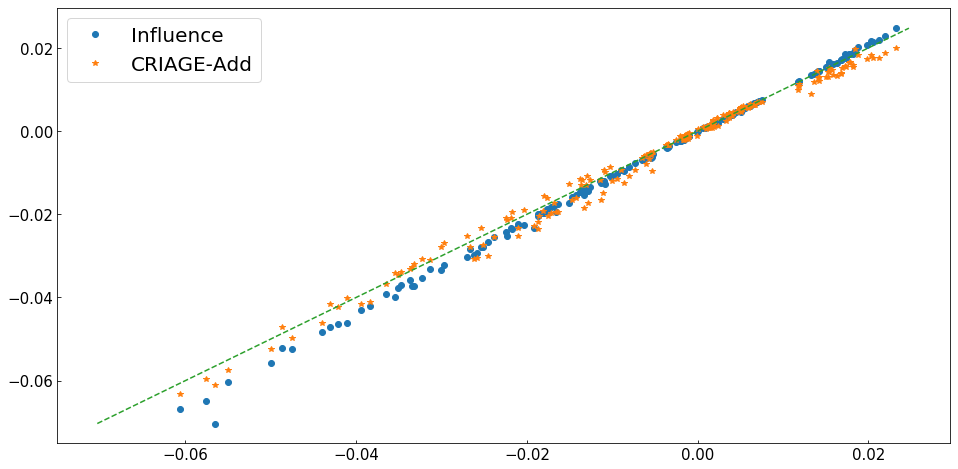

In [10]:
plt.figure(figsize=(16,8))

plt.plot(triple_score_ranking_actual,triple_score_ranking_hessian,'o',label='Influence')
plt.plot(triple_score_ranking_actual,triple_score_ranking_e2_hessian,'*',label='CRIAGE-Add')
plt.plot([dnlimit,uplimit], [dnlimit,uplimit],'--')
plt.legend(prop={'size':20})
plt.tick_params(direction='in',labelsize=15)
plt.plot()